# BEST:
# BEST METHOD KEEP THIS:

In [313]:
import numpy as np
import sympy as sp
from typing import List, Tuple, Dict, Any, Set
from scipy.stats import levy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

class all_parameter_generation:
    """
    Generate state transitions and random parameters (a, b, c, enzyme) for an n-site phosphorylation model.

    Args:
        n: number of sites (int)
        distribution: distribution name ("gamma" supported)
        params: parameters for the distribution (for gamma: [shape, scale])
        verbose: if True, prints transitions and matrices
    """
    def __init__(self, n: int, reaction_types: str, distribution: str, distribution_paramaters: List[float], verbose: bool = False):
        self.n = n
        self.num_states = 2 ** n
        self.distribution = distribution
        self.params = distribution_paramaters
        self.reaction_types = reaction_types
        self.verbose = verbose
        self.rng = np.random.default_rng()
        
    @staticmethod
    def padded_binary(i: int, n: int) -> str:
        return bin(i)[2:].zfill(n)

    @staticmethod
    def binary_string_to_array(string: str) -> np.ndarray:
        return np.array([int(i) for i in string], dtype=int)

    def calculate_valid_transitions(self) -> Tuple[List[List[Any]], List[List[Any]]]:
        """
        Returns:
            valid_X_reactions: list of [state_i_str, state_j_str, i, j, "E"]
            valid_Y_reactions: list of [state_i_str, state_j_str, i, j, "F"]
        """
        all_states = [self.padded_binary(i, self.n) for i in range(self.num_states)]

        valid_difference_vectors: Set[Tuple[int, ...]] = set()
        valid_X_reactions: List[List[Any]] = []
        valid_Y_reactions: List[List[Any]] = []

        for i in range(self.num_states):
            arr_i = self.binary_string_to_array(all_states[i])
            for j in range(self.num_states):
                if i == j:
                    continue
                arr_j = self.binary_string_to_array(all_states[j])
                diff = arr_j - arr_i
                # if self.reaction_types == "distributive":
                    
                hamming_weight = np.sum(np.abs(diff))

                if hamming_weight == 1:
                    # +1 -> phosphorylation (E), -1 -> dephosphorylation (F)
                    element = "E" if np.any(diff == 1) else "F"
                    if element == "E":
                        if self.verbose:
                            print(f"{all_states[i]} --> {all_states[j]} (E), {i}, {j}")
                        valid_X_reactions.append([all_states[i], all_states[j], i, j, element])
                    else:
                        if self.verbose:
                            print(f"{all_states[i]} --> {all_states[j]} (F), {i}, {j}")
                        valid_Y_reactions.append([all_states[i], all_states[j], i, j, element])
                    valid_difference_vectors.add(tuple(diff))

        return valid_X_reactions, valid_Y_reactions
    
    def alpha_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray,
                                            Dict[int, List[int]], Dict[int, List[int]],
                                            Dict[int, List[int]], Dict[int, List[int]]]:
        
        valid_X_reactions, valid_Y_reactions = self.calculate_valid_transitions()

        shape, scale = self.params

        alpha_matrix = np.zeros((self.num_states, self.num_states))

        for _, _, i, j, _ in valid_X_reactions:

            alpha_matrix[i][j] = self.rng.gamma(shape, scale)

        return alpha_matrix

    def beta_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray,
                                            Dict[int, List[int]], Dict[int, List[int]],
                                            Dict[int, List[int]], Dict[int, List[int]]]:
        
        valid_X_reactions, valid_Y_reactions = self.calculate_valid_transitions()

        shape, scale = self.params
        beta_matrix = np.zeros((self.num_states, self.num_states))
        
        for _, _, i, j, _ in valid_Y_reactions:

            beta_matrix[i][j] = self.rng.gamma(shape, scale)

        return beta_matrix
    
    def k_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray]:
        # if self.distribution != "gamma":
        #     raise NotImplementedError("Only 'gamma' distribution implemented for a_parameter_generation")
        shape, scale = self.params
        if self.distribution == "gamma":
            k_positive_rates = self.rng.gamma(shape, scale, self.num_states - 1)
            k_negative_rates = self.rng.gamma(shape, scale, self.num_states - 1)
        if self.distribution == "levy":
            k_positive_rates = levy.rvs(loc=shape, scale=scale, size=self.num_states - 1, random_state=self.rng)
            k_negative_rates = levy.rvs(loc=shape, scale=scale, size=self.num_states - 1, random_state=self.rng)
        # k_positive_rates[-1] = 0
        # k_negative_rates[-1] = 0
        
        return k_positive_rates, k_negative_rates

    def p_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray]:
        
        # if self.distribution != "gamma":
        #     raise NotImplementedError("Only 'gamma' distribution implemented for b_parameter_generation")
        shape, scale = self.params
        if self.distribution == "gamma":
            p_positive_rates = self.rng.gamma(shape, scale, self.num_states - 1)
            p_negative_rates = self.rng.gamma(shape, scale, self.num_states - 1)
        if self.distribution == "levy":
            p_positive_rates = levy.rvs(loc=shape, scale=scale, size=self.num_states - 1, random_state=self.rng)
            p_negative_rates = levy.rvs(loc=shape, scale=scale, size=self.num_states - 1, random_state=self.rng)
        # p_positive_rates[0] = 0
        # p_negative_rates[0] = 0

        return p_positive_rates, p_negative_rates
    

def phosphorylation_solver_adjsuted(state_array, n,
                                  alpha_matrix, beta_matrix,
                                  k_positive_rates, k_negative_rates,
                                  p_positive_rates, p_negative_rates,
                                  k_positive_matrix, k_negative_matrix, 
                                  p_positive_matrix, p_negative_matrix,
                                  diagonal_loss_alpha_matrix, diagonal_loss_beta_matrix):

    N = 2**n
    ones_vec = np.ones(N)
    if state_array.size != 3 * N + 2:
        raise ValueError(f"Expected state_array length {3 * N + 2}, got {state_array.size} for n={n}")

    if k_positive_rates[-1] != 0 or k_negative_rates[-1] != 0:
        raise ValueError("Manual error raised: k_positive_rates[-1] and k_negative_rates[-1] must be zero to enforce boundary condition b_n = 0")
    
    if p_positive_rates[0] != 0 or p_negative_rates[0] != 0:
        raise ValueError("Manual error raised: p_positive_rates[0] and p_negative_rates[0] must be zero to enforce boundary condition c_0 = 0")
    
    a = state_array[0: N].astype(float)
    b = state_array[N: 2*N].astype(float)
    c = state_array[2*N: 3*N].astype(float)
    # b[-1] = 0
    # c[0] = 0
    x = float(state_array[-2])
    y = float(state_array[-1])

    if b[-1] != 0 or c[0] != 0:
        raise ValueError("Manual error raised: b_n must be 0 and c_0 must be 0 at all times")

    a_dot = (k_negative_matrix @ b) + (p_negative_matrix @ c) + (alpha_matrix.T @ b) + (beta_matrix.T @ c) \
            - x * (k_positive_matrix @ a) - y * (p_positive_matrix @ a)
    
    b_dot = x * (k_positive_matrix @ a) - (k_negative_matrix @ b) - diagonal_loss_alpha_matrix @ b
    c_dot = y * (p_positive_matrix @ a) - (p_negative_matrix @ c) - diagonal_loss_beta_matrix @ c

    # Enforce boundary conditions for all time: b_n = 0 and c_0 = 0
    b_dot[-1] = 0
    c_dot[0] = 0

    # To ensure that the sums in x and y dot dont go over incorrect indices, 
    # we zero out the last element of a for x_dot and the first element of a for y_dot
    # a_adjusted_for_x_dot = a.copy(); a_adjusted_for_x_dot[-1] = 0
    # a_adjusted_for_y_dot = a.copy(); a_adjusted_for_y_dot[0] = 0

    x_dot = -x * (k_positive_rates.T @ a) + (ones_vec.T @ ((k_negative_matrix + diagonal_loss_alpha_matrix) @ b))
    y_dot = -y * (p_positive_rates.T @ a) + (ones_vec.T @ ((p_negative_matrix + diagonal_loss_beta_matrix) @ c))

    return np.concatenate((a_dot, b_dot, c_dot, np.array([x_dot, y_dot])))

    
def phosphorylation_ODE_system(t, state_array, n,
                                  alpha_matrix, beta_matrix,
                                  k_positive_rates, k_negative_rates,
                                  p_positive_rates, p_negative_rates,
                                  k_positive_matrix, k_negative_matrix, 
                                  p_positive_matrix, p_negative_matrix,
                                  diagonal_loss_alpha_matrix, diagonal_loss_beta_matrix):

    N = 2**n
    ones_vec = np.ones(N)
    if state_array.size != 3 * N + 2:
        raise ValueError(f"Expected state_array length {3 * N + 2}, got {state_array.size} for n={n}")

    if k_positive_rates[-1] != 0 or k_negative_rates[-1] != 0:
        raise ValueError("Manual error raised: k_positive_rates[-1] and k_negative_rates[-1] must be zero to enforce boundary condition b_n = 0")
    
    if p_positive_rates[0] != 0 or p_negative_rates[0] != 0:
        raise ValueError("Manual error raised: p_positive_rates[0] and p_negative_rates[0] must be zero to enforce boundary condition c_0 = 0")
    
    a = state_array[0: N].astype(float)
    b = state_array[N: 2*N].astype(float)
    c = state_array[2*N: 3*N].astype(float)
    x = float(state_array[-2])
    y = float(state_array[-1])
    # print("a", a)
    # print("b", b)
    # print("c", c)
    # print("x", x)
    # print("y", y)
    # print("alpha_matrix:\n", alpha_matrix)
    # print("beta_matrix:\n", beta_matrix)
    # print("k_positive_rates:", k_positive_rates)
    # print("k_negative_rates:", k_negative_rates)
    # print("p_positive_rates:", p_positive_rates)
    # print("p_negative_rates:", p_negative_rates)
    if b[-1] != 0 or c[0] != 0:
        raise ValueError("Manual error raised: b_n must be 0 and c_0 must be 0 at all times")

    a_dot = (k_negative_matrix @ b) + (p_negative_matrix @ c) + (alpha_matrix.T @ b) + (beta_matrix.T @ c) \
            - x * (k_positive_matrix @ a) - y * (p_positive_matrix @ a)
    
    b_dot = x * (k_positive_matrix @ a) - (k_negative_matrix @ b) - diagonal_loss_alpha_matrix @ b
    c_dot = y * (p_positive_matrix @ a) - (p_negative_matrix @ c) - diagonal_loss_beta_matrix @ c

    # Enforce boundary conditions for all time: b_n = 0 and c_0 = 0
    b_dot[-1] = 0
    c_dot[0] = 0

    # To ensure that the sums in x and y dot dont go over incorrect indices, 
    # we zero out the last element of a for x_dot and the first element of a for y_dot
    # a_adjusted_for_x_dot = a.copy(); a_adjusted_for_x_dot[-1] = 0
    # a_adjusted_for_y_dot = a.copy(); a_adjusted_for_y_dot[0] = 0

    x_dot = -x * (k_positive_rates.T @ a) + (ones_vec.T @ ((k_negative_matrix + diagonal_loss_alpha_matrix) @ b))
    y_dot = -y * (p_positive_rates.T @ a) + (ones_vec.T @ ((p_negative_matrix + diagonal_loss_beta_matrix) @ c))

    # uncomment this code to check conservation
    # conserved_rate = ones_vec @ (a_dot + b_dot + c_dot)
    # print(conserved_rate)  # should be ~0 (mod numerical error)
    # # check kinase conservation
    # print("dX_tot/dt =", x_dot + ones_vec @ b_dot)
    # # check phosphatase conservation
    # print("dY_tot/dt =", y_dot + ones_vec @ c_dot)

    # if n = 1, we know anayltically what the fixed points should be, and so we will check:

    return np.concatenate((a_dot, b_dot, c_dot, np.array([x_dot, y_dot])))


def MATTIA(t, state_array, n,
            alpha_matrix, beta_matrix,
            k_positive_rates, k_negative_rates,
            p_positive_rates, p_negative_rates, a_tot, x_tot, y_tot):

    N = 2**n
    ones_vec = np.ones(N - 1)
    ones_vec_full = np.ones(N)
    # if state_array.size != 3 * N + 2:
    #     raise ValueError(f"Expected state_array length {3 * N + 2}, got {state_array.size} for n={n}")

    # if k_positive_rates[-1] != 0 or k_negative_rates[-1] != 0:
    #     raise ValueError("Manual error raised: k_positive_rates[-1] and k_negative_rates[-1] must be zero to enforce boundary condition b_n = 0")
    
    # if p_positive_rates[0] != 0 or p_negative_rates[0] != 0:
    #     raise ValueError("Manual error raised: p_positive_rates[0] and p_negative_rates[0] must be zero to enforce boundary condition c_0 = 0")
    
    a = state_array[0: N].astype(float)
    b = state_array[N: 2*N - 1].astype(float)
    c = state_array[2*N - 1: 3*N - 2].astype(float)
    
    x = float(state_array[-2])
    y = float(state_array[-1])

    Kp = np.diag(np.append(k_positive_rates, 0))
    # Km = np.diag(k_negative_rates);  Km = np.vstack([Km, np.zeros((1, len(k_negative_rates)))]) 
    Km = np.append(np.diag(k_negative_rates), np.zeros((1, len(k_negative_rates))), axis=0)

    Pp = np.diag(np.insert(p_positive_rates, 0, 0))
    Pm = np.vstack([np.zeros((1, len(p_negative_rates))), np.diag(p_negative_rates)])    # print("a", a)

    adjusted_alpha_mat = np.delete(alpha_matrix, -1, axis = 0)
    adjusted_beta_mat = np.delete(beta_matrix, 0, axis = 0)

    Da = np.diag(alpha_matrix[:-1, 1:] @ ones_vec)
    Db = np.diag(beta_matrix[1:, :-1] @ ones_vec)

    U = np.diag(k_negative_rates)
    I = np.diag(p_negative_rates)
    Q = Kp[:-1, :]
    D = np.delete(Pp, 0, axis=0)

    M = U + Da
    N = I + Db

    G = Km + adjusted_alpha_mat.T
    H = Pm + adjusted_beta_mat.T
    M_inv = np.linalg.inv(M); N_inv = np.linalg.inv(N)

    L1 = G @ M_inv @ Q - Kp; L2 = H @ N_inv @ D - Pp
    W1 = M_inv @ Q; W2 = N_inv @ D

    ##### SCALING    

    p = x_tot / y_tot
    k_scaling = k_negative_rates[0]

    L1 = L1 * (k_scaling / a_tot); L2 = L2 * (k_scaling / a_tot)
    W1 = W1 * a_tot; W2 = W2 * a_tot

    a_dot_vec = ((p * L1 @ a) / (1 + ones_vec @ W1 @ a)) + ((L2 @ a) / (1 + ones_vec @ W2 @ a)) 
    
    # a_dot = (Km @ b) + (Pm @ c) + (adjusted_alpha_mat.T @ b) + (adjusted_beta_mat.T @ c) \
    #         - x * (Kp @ a) - y * (Pp @ a)
    
    # b_dot = x * (Q @ a) - (M) @ b
    # c_dot = y * (D @ a) - (N) @ c

    # x_dot = -1*ones_vec.T @ b_dot
    # y_dot = -1*ones_vec.T @ c_dot

    ##### uncomment this code to check conservation
    # conserved_rate = np.ones(N) @ a_dot + ones_vec @ (b_dot + c_dot)
    # print(conserved_rate)  # should be ~0 (mod numerical error)
    # # check kinase conservation
    # print("dX_tot/dt =", x_dot + ones_vec @ b_dot)
    # # check phosphatase conservation
    # print("dY_tot/dt =", y_dot + ones_vec @ c_dot)

    # if n = 1, we know anayltically what the fixed points should be, and so we will check:

    # return np.concatenate((a_dot, b_dot, c_dot, np.array([x_dot, y_dot])))
    return a_dot_vec

def phosphorylation_system_solver(parameters_tuple, initial_states_array):
    # n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates, k_positive_matrix, k_negative_matrix, p_positive_matrix, p_negative_matrix, diagonal_loss_alpha_matrix, diagonal_loss_beta_matrix = parameters_tuple
    a_tot = 100
    x_tot = 0.1
    y_tot = 0.1
    # creating initial_state_array, and enforce that B_n = 0 and C_0 = 0
    # params = (n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates, k_positive_matrix, k_negative_matrix, p_positive_matrix, p_negative_matrix, diagonal_loss_alpha_matrix, diagonal_loss_beta_matrix)
    n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates, a_tot, x_tot, y_tot = parameters_tuple
    N = 2**n

    #### SCALING TIME
    initial_t = 0
    final_t = 50
    scaling_factor = a_tot / (y_tot * k_negative_rates[0])
    t_span = (scaling_factor * initial_t, scaling_factor * final_t)
    print(t_span)
    # t_span = t_span * a_tot / (y_tot * k_negative_rates)
    
    t_array = np.linspace(t_span[0], t_span[1], 500)
    sol = solve_ivp(MATTIA, t_span = t_span, t_eval = t_array, y0=np.asarray(initial_states_array, dtype=float), args = parameters_tuple)

    a_solution_stack = np.stack([sol.y[i] for i in range(0, N)])
    # b_solution_stack = np.stack([sol.y[i] for i in range(N, 2*N - 1)]) 
    # c_solution_stack = np.stack([sol.y[i] for i in range(2*N - 1, 3*N - 2)]) 
    # x_solution = sol.y[-2]
    # y_solution = sol.y[-1]

    plt.figure(figsize = (8, 6))
    plt.style.use('seaborn-v0_8-whitegrid')

    cmap = plt.get_cmap('tab10')

    def color_for_species(idx):
        return cmap(idx % cmap.N)

    for i in range(a_solution_stack.shape[0]):
        color = color_for_species(i)
        plt.plot(sol.t, a_solution_stack[i], color=color, label = f"$A_{i}$", lw=2, alpha = 0.75)
        print(f"final A_{i} = {a_solution_stack[i][-1]}")

    # for i in range(b_solution_stack.shape[0]):
    #     color = color_for_species(i + a_solution_stack.shape[0])
    #     plt.plot(sol.t, b_solution_stack[i], color=color, label = f"$B_{i}$", lw=1.5, linestyle='-', alpha = 0.75)
    #     print(f"final B_{i} = {b_solution_stack[i][-1]}")

    # for i in range(c_solution_stack.shape[0]):
    #     color = color_for_species(i + a_solution_stack.shape[0] + b_solution_stack.shape[0] - 1)
    #     plt.plot(sol.t, c_solution_stack[i], color=color, label=f"$C_{i+1}$", lw=1, linestyle='--', alpha = 1)
    #     print(f"final C_{i+1} = {c_solution_stack[i][-1]}")

    # print(f"final X = {x_solution[-1]}")
    # print(f"final Y = {y_solution[-1]}")

    plt.title(f"Plotting phosphorylation dynamics for n = {n}")
    # plt.plot(sol.t, x_solution, color='black', label="$X$", lw=1.75, alpha = 0.75)
    # plt.plot(sol.t, y_solution, color='gray', label="$Y$", lw=1, alpha = 0.75)
    plt.ylabel("concentration")
    plt.xlabel("time (s)")
    plt.minorticks_on()
    plt.tight_layout()
    plt.xlim(t_span[0] - 1, t_span[1] + 1)
    plt.ylim()
    plt.legend(frameon=False)
    plt.show()

    # WRITE CODE THAT EXPORTS DATA AS FILE



A0 scaled fixed point = 0.0002740877414335999
A1 scaled fixed point = 0.9831409706943997
A2 scaled fixed point = 0.0011413421902549735
A3 scaled fixed point = 0.01544359937391182
(np.float64(0.0), np.float64(58356.20513713319))
final A_0 = 8.188227768016731e-06
final A_1 = 12.432305340118566
final A_2 = 0.0058004747093926366
final A_3 = 87.56188599694444


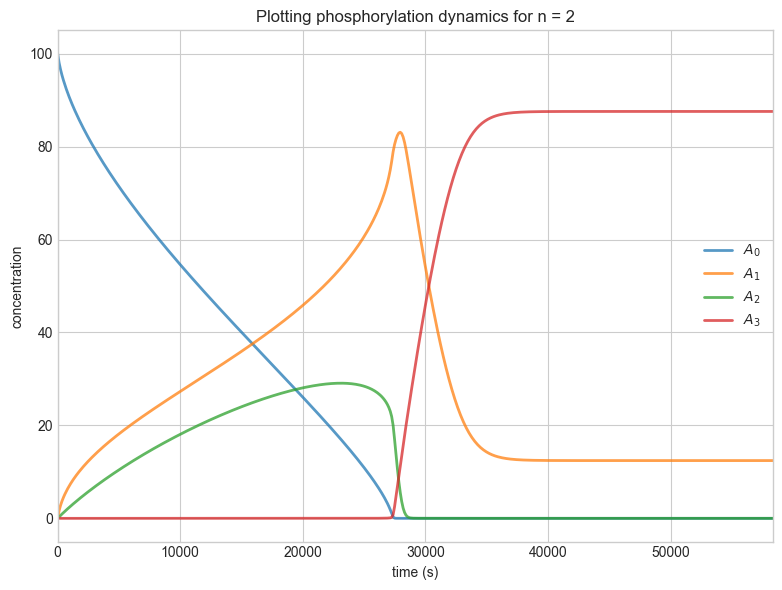

In [314]:
import numpy as np
n = 2
N = 2**n
a_tot = 100
x_tot = 0.1
y_tot = 0.1
##################### constructing initial parameter vectors/matrices
# gen = all_parameter_generation(n, "distributive", "gamma", (0.5, 1), verbose = False)
# alpha_matrix = gen.alpha_parameter_generation()
# beta_matrix = gen.beta_parameter_generation()
# k_positive_rates, k_negative_rates = gen.k_parameter_generation()
# p_positive_rates, p_negative_rates = gen.p_parameter_generation()

arr = np.loadtxt('test_500.csv', skiprows = 1, delimiter=',')
# print(arr[0])
# print(len(arr[0]))
index = 1
# print(arr[index])
# a_0_stable_fp, a_1_stable_fp, a_2_stable_fp, a_3_stable_fp, a_tot, x_tot, y_tot, alpha_matrix_parameters, beta_matrix_parameters, k_+_parameters, k_-_parameters, p_+_parameters, p_-_parameters"
alpha_matrix_parameters = np.array(arr[index][7:11])
beta_matrix_parameters = np.array(arr[index][11:15])
k_positive_rates = np.array(arr[index][15:18])
k_negative_rates = np.array(arr[index][18:21])
p_positive_rates = np.array(arr[index][21:24])
p_negative_rates = np.array(arr[index][24:27])
print("A0 scaled fixed point =", arr[index][0] / a_tot)
print("A1 scaled fixed point =", arr[index][1] / a_tot)
print("A2 scaled fixed point =", arr[index][2] / a_tot)
print("A3 scaled fixed point =", arr[index][3] / a_tot)

# alpha_matrix_parameters = np.array(arr[7:11])
# beta_matrix_parameters = np.array(arr[11:15])
# k_positive_rates = np.array(arr[15:18])
# k_negative_rates = np.array(arr[18:21])
# p_positive_rates = np.array(arr[21:24])
# p_negative_rates = np.array(arr[24:27])


alpha_matrix = np.array([[0, alpha_matrix_parameters[0], alpha_matrix_parameters[1], 0],
                        [0, 0, 0, alpha_matrix_parameters[2]],
                        [0, 0, 0, alpha_matrix_parameters[3]],
                        [0, 0, 0, 0]])
beta_matrix = np.array([[0, 0, 0, 0],
                        [beta_matrix_parameters[0], 0, 0, 0],
                        [beta_matrix_parameters[1], 0, 0, 0],
                        [0, beta_matrix_parameters[2], beta_matrix_parameters[3], 0]])
#####################
# alpha_matrix = np.array([[0, 1],
#                          [0, 0]])
# beta_matrix = np.array([[0, 0],  
#                        [1, 0]])
# k_positive_rates = np.array([1, 0])
# k_negative_rates = np.array([1, 0])
# p_positive_rates = np.array([0, 1])
# p_negative_rates = np.array([0, 1])
#####################

####################
# ones_vec = np.ones(N)

# alpha_matrix = np.array([[0, 1, 1, 0],
#                         [0, 0, 0, 1],
#                         [0, 0, 0, 1],
#                         [0, 0, 0, 0]])
# beta_matrix = np.array([[0, 0, 0, 0],
#                         [1, 0, 0, 0],
#                         [1, 0, 0, 0],
#                         [0, 1, 1, 0]])
# k_positive_rates = np.array([1, 1, 1, 0])
# k_negative_rates = np.array([1, 1, 1, 0])
# p_positive_rates = np.array([0, 1, 1, 1])
# p_negative_rates = np.array([0, 1, 1, 1])
#################### constructing additional needed matrices

# k_positive_matrix = np.diag(k_positive_rates); k_negative_matrix = np.diag(k_negative_rates)
# p_positive_matrix = np.diag(p_positive_rates); p_negative_matrix = np.diag(p_negative_rates)
# diagonal_loss_alpha_matrix = np.diag(alpha_matrix @ ones_vec); diagonal_loss_beta_matrix = np.diag(beta_matrix @ ones_vec)


initial_states_array = np.insert(np.zeros(N - 1), 0, a_tot)

parameters_tuple = (n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates, a_tot, x_tot, y_tot)
phosphorylation_system_solver(parameters_tuple, initial_states_array)

In [303]:
initial_t = 0
final_t = 50
t_span = (initial_t, final_t)
print(t_span)
scaling_factor = a_tot / (y_tot * k_negative_rates[0])
print(scaling_factor)
t_span_scaled = tuple(i * scaling_factor for i in t_span)
print(t_span_scaled)

(0, 50)
1167.1241027426638
(np.float64(0.0), np.float64(58356.20513713319))


In [301]:
original_tuple = (2, 4, 6)
scalar = 3
multiplied_elements_tuple = tuple(item * scalar for item in original_tuple)
print(multiplied_elements_tuple)

(6, 12, 18)


In [ ]:
import sympy as sp

# --- user parameters ---
prefix = ""
n = 1
bigN = 2**n   # number of a-variables

gen = all_parameter_generation(n, "distributive", "gamma", (0.5, 1), verbose = False)
alpha_matrix = gen.alpha_parameter_generation()
beta_matrix = gen.beta_parameter_generation()
k_positive_rates, k_negative_rates = gen.k_parameter_generation()
p_positive_rates, p_negative_rates = gen.p_parameter_generation()
# Example numeric values for the rate vectors (length = bigN-1).
# Replace these with your actual floats.
kplus_vals  = [0.5]         # length bigN-1
kminus_vals = [0.2]         # length bigN-1
pplus_vals  = [0.3]         # length bigN-1
pminus_vals = [0.4]         # length bigN-1
x_tot_value = 1
y_tot_value = 1

# --- symbolic state vars ---
a_syms = sp.symbols([f"{prefix}a_{i}" for i in range(bigN)])
b_syms = sp.symbols([f"{prefix}b_{i}" for i in range(bigN - 1)])
c_syms = sp.symbols([f"{prefix}c_{i}" for i in range(1, bigN)])
x_sym, y_sym = sp.symbols(f"{prefix}x {prefix}y")
x = x_sym; y = y_sym

x_tot_sym, y_tot_sym = sp.symbols(f"{prefix}x_tot {prefix}y_tot")
x_tot = sp.Float(x_tot_value); y_tot = sp.Float(y_tot_value)

a = sp.Matrix(bigN, 1, lambda i,j: a_syms[i])

# ones across the (N-1) columns used in your expression
ones_vec = sp.ones(1, bigN - 1)

# --- create numeric (float) diagonals but as sympy Floats ---
# Build Kp as diag(kplus_0, ..., kplus_{N-2}, 0)  -> size bigN x bigN
Kp = sp.diag(*[sp.Float(v) for v in kplus_vals], sp.Float(0))

# Build Km as N x (N-1) matrix (to match Alpha.T shape later)
Km_small = sp.diag(*[sp.Float(v) for v in kminus_vals])  # (N-1)x(N-1)
Km = Km_small.row_insert(len(kminus_vals), sp.zeros(1, len(kminus_vals)))  # becomes N x (N-1)

# Pp as N x N with leading zero then pplus entries on diag offset 1..N-1
Pp = sp.diag(sp.Float(0), *[sp.Float(v) for v in pplus_vals])

# Pm as N x (N-1) like Km: create (N-1)x(N-1) diag then add a zero row on top
Pm_small = sp.diag(*[sp.Float(v) for v in pminus_vals])  # (N-1)x(N-1)
Pm = Pm_small.row_insert(0, sp.zeros(1, len(pminus_vals)))  # becomes N x (N-1)

# --- compute allowed transitions (use your function) ---
# MUST provide calculate_valid_transitions(n); I assume it returns
# valid_X_reactions and valid_Y_reactions in the same tuple format you used.
valid_X_reactions, valid_Y_reactions = calculate_valid_transitions(n)

# Build Alpha and Beta with symbols only at allowed (j,k)
Alpha = sp.zeros(bigN - 1, bigN)
Beta  = sp.zeros(bigN - 1, bigN)
for (_, _, j, k, _) in valid_X_reactions:
    Alpha[j, k] = sp.symbols(f"{prefix}alpha_{j}_{k}")
for (_, _, j, k, _) in valid_Y_reactions:
    Beta[j - 1, k] = sp.symbols(f"{prefix}beta_{j}_{k}")

# Tilded versions used for row sums (size NxN)
Alpha_tild = sp.zeros(bigN, bigN)
Beta_tild  = sp.zeros(bigN, bigN)
for (_, _, j, k, _) in valid_X_reactions:
    Alpha_tild[j, k] = sp.symbols(f"{prefix}alpha_{j}_{k}")
for (_, _, j, k, _) in valid_Y_reactions:
    Beta_tild[j, k] = sp.symbols(f"{prefix}beta_{j}_{k}")

ones = sp.Matrix([1] * bigN)
Alpha_row_sums = Alpha_tild * ones
Beta_row_sums = Beta_tild * ones

DAlpha = sp.diag(*[Alpha_row_sums[i, 0] for i in range(bigN - 1)])   # (N-1)x(N-1)
DBeta  = sp.diag(*[Beta_row_sums[i, 0] for i in range(1, bigN)])    # (N-1)x(N-1)

# --- matrices using the numeric float vectors (converted to sp.Float) ---
# U and I are (N-1)x(N-1)
U = sp.diag(*[sp.Float(v) for v in kminus_vals])   # (N-1)x(N-1)
I = sp.diag(*[sp.Float(v) for v in pminus_vals])   # (N-1)x(N-1)

# Q and D are (N-1) x N after a column insert (matching original code)
Q = sp.diag(*[sp.Float(v) for v in kplus_vals])   # (N-1)x(N-1)
Q = Q.col_insert(len(kplus_vals), sp.zeros(len(kplus_vals), 1))  # now (N-1)xN

D = sp.diag(*[sp.Float(v) for v in pplus_vals])   # (N-1)x(N-1)
D = D.col_insert(0, sp.zeros(len(pplus_vals), 1)) # now (N-1)xN

# G, H, M, N matrices (note: M,N used as var names in your original code -> rename)
G = Km + Alpha.T      # Km is N x (N-1), Alpha.T is N x (N-1)
H = Pm + Beta.T       # Pm is N x (N-1), Beta.T is N x (N-1)

M_mat = U + DAlpha    # (N-1)x(N-1)
N_mat = I + DBeta     # (N-1)x(N-1)

M_inv = M_mat.inv()
N_inv = N_mat.inv()

L1 = G * M_inv * Q - Kp
L2 = H * N_inv * D - Pp

W1 = M_inv * Q
W2 = N_inv * D

# final a_dot symbolic (each entry will be symbolic polynomial in a_syms, alpha_*, beta_* ...)
a_dot = x_tot_value * L1 * (1 / (1 + (ones_vec * W1 * a)[0])) * a + y_tot_value * L2 * (1 / (1 + (ones_vec * W2 * a)[0])) * a

# show result
sp.Matrix(a_dot)           # prints the symbolic vector
# optionally expand entries
a_dot_expanded = sp.Matrix([sp.simplify(sp.expand(elem)) for elem in a_dot])
a_dot_expanded
